"""
# ECG Feature Extraction Pipeline
**Author:** Amirhossein Pourabdollah
**Project:** Neurovisceral Decoding: Emotional Arousal and Cognitive Performance

## Overview
This notebook implements a signal processing pipeline to extract Heart Rate Variability (HRV) features from raw ECG data using the `NeuroKit2` library. The pipeline includes signal cleaning, R-peak detection, and the calculation of Time-domain, Frequency-domain, and Non-linear indices.

**Input:** Raw ECG signal (single channel).
**Output:** Processed HRV feature matrix.
"""


In [ ]:
#Import Dependencies and libraries
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
import os

# Plot settings for better readability
plt.rcParams['figure.figsize'] = [15, 6]  # Set default figure size
print("Libraries imported successfully.")

Libraries imported successfully.


In [ ]:
#Load Data
import os
import pandas as pd

file_path = os.path.join('Data', 'sample_ecg.csv')

if os.path.exists(file_path):
    data = pd.read_csv(file_path)
    sampling_rate = 512
    print(f"Data loaded: {len(data)} samples.")
else:
    print("Error: File not found.")
    print("Make sure the 'Data' folder is in the same directory as this notebook.")

Data loaded: 614400 samples.


## 2. Visual Inspection of Raw Data
Before processing, we visualize a 10-second segment of the raw signal to ensure signal integrity and identify potential artifacts.

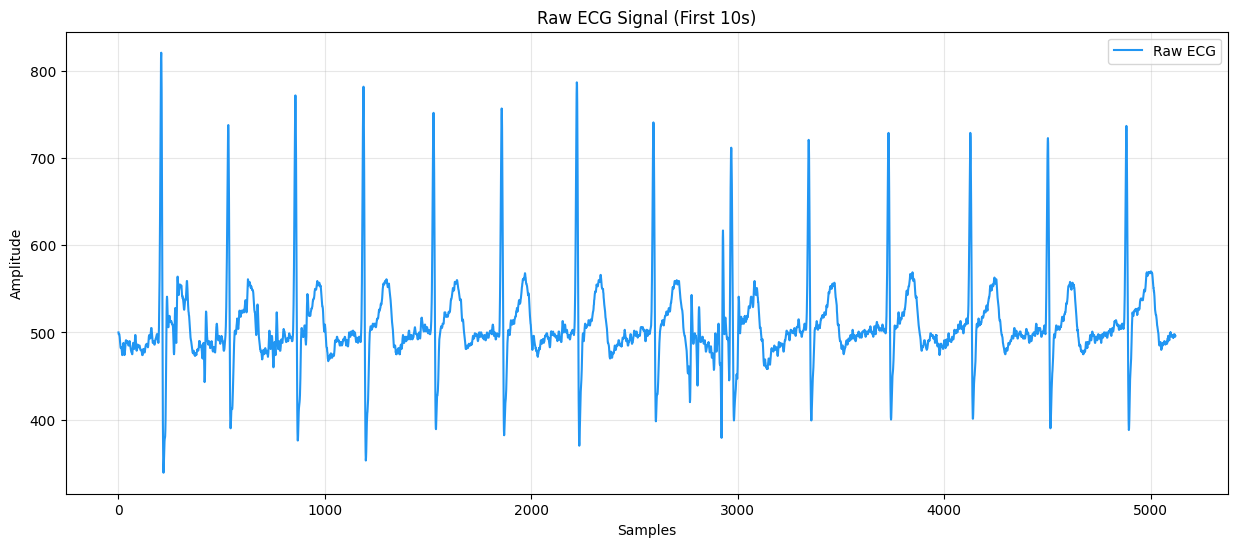

In [ ]:
# Visualize the first 10 seconds (10 * 512 = 5120 samples)
# Sampling rate is set to 512 Hz as per the device specifications
limit = 10 * sampling_rate
plt.plot(data['ECG'][:limit], color='#2196F3', label='Raw ECG')
plt.title('Raw ECG Signal (First 10s)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3. Signal Processing & Peak Detection
We utilize the `neurokit2` pipeline to clean the signal. This includes:
- **Filtering:** Removing powerline noise (50Hz) and motion artifacts.
- **R-Peak Detection:** Identifying the QRS complexes to calculate RR-intervals.

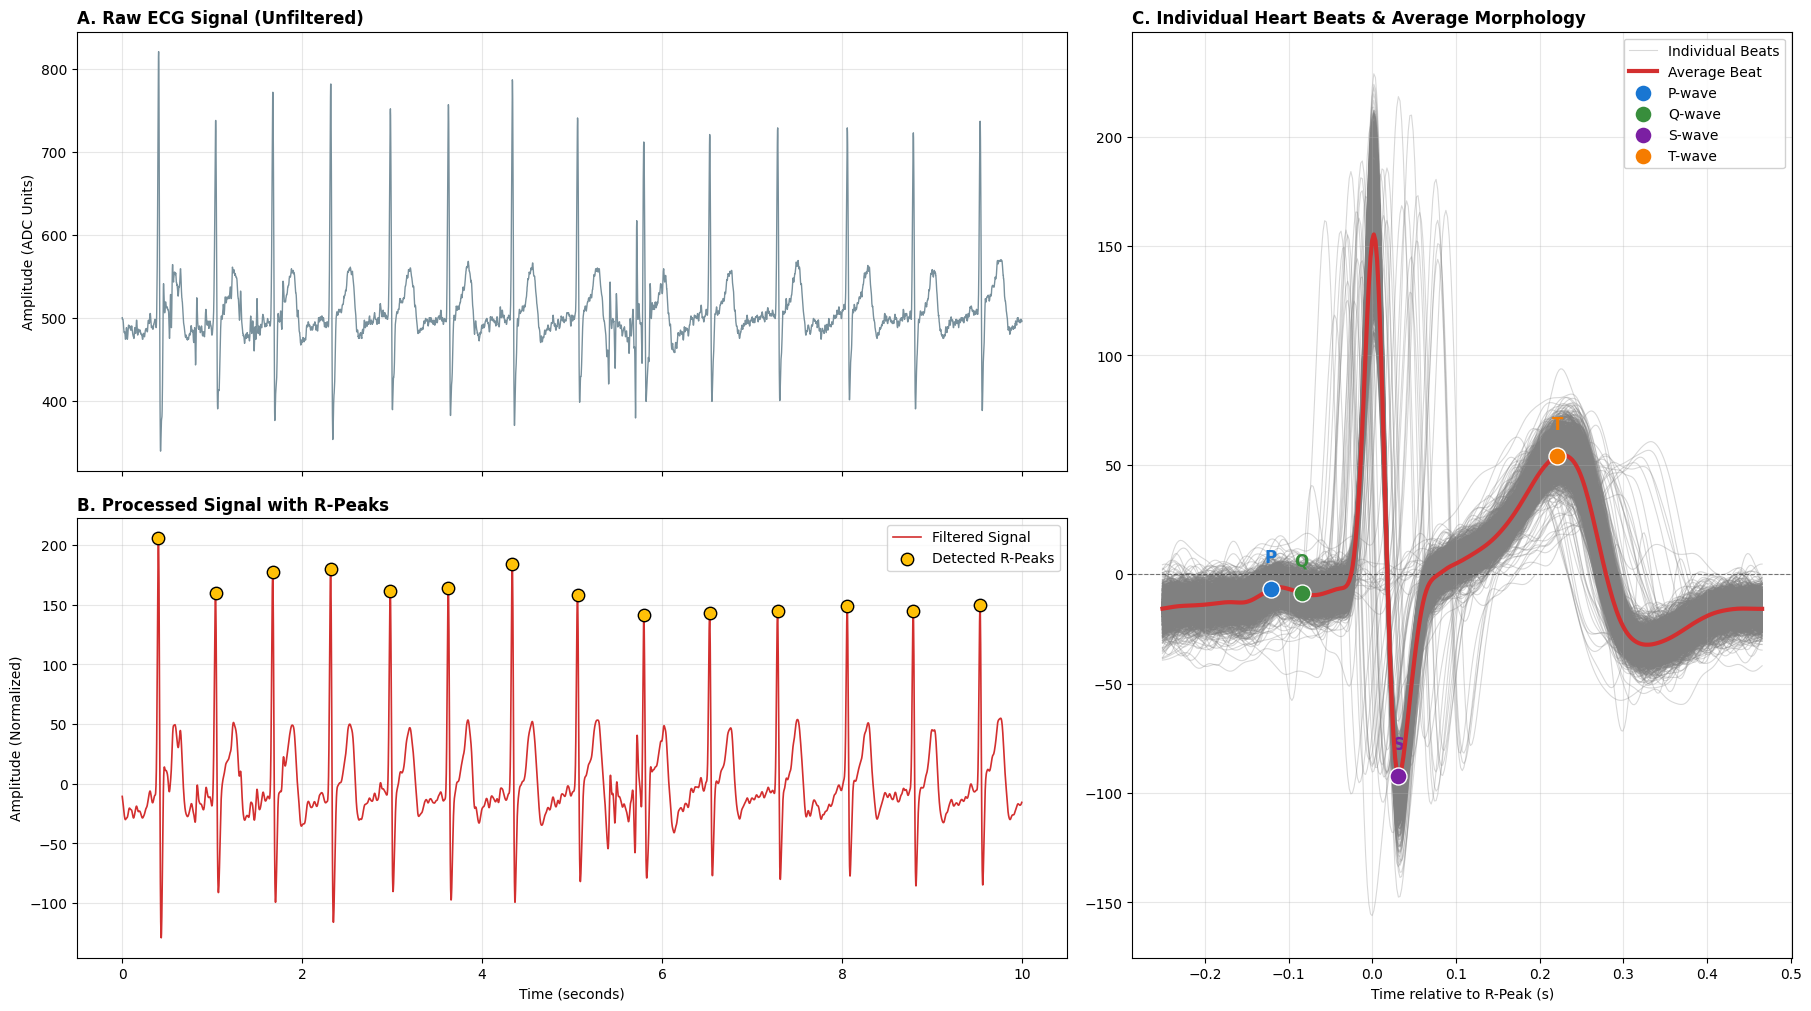

In [ ]:
import matplotlib.pyplot as plt
import neurokit2 as nk
import pandas as pd
import numpy as np

# # Prerequisite Note: Ensure 'data' (DataFrame with 'ECG' column) and 'sampling_rate' are defined before running.
# Example:
# data = pd.read_csv('sample_ecg.csv')


# ---------------------------------------------------------
# 1. Process Signal & Extract Features
# ---------------------------------------------------------
# Clean signal and find R-peaks
signals, info = nk.ecg_process(data['ECG'], sampling_rate=sampling_rate)

# Delineate waves (P, Q, S, T) on the full signal first to avoid segmentation errors
try:
    _, waves = nk.ecg_delineate(signals["ECG_Clean"], info["ECG_R_Peaks"], sampling_rate=sampling_rate, method='dwt')
except Exception as e:
    print(f"Delineation warning: {e}")
    waves = {} 

# Segment signal into individual heartbeats centered around R-peaks
epochs = nk.ecg_segment(signals, rpeaks=info["ECG_R_Peaks"], sampling_rate=sampling_rate, show=False)

# ---------------------------------------------------------
# 2. Visualization Setup
# ---------------------------------------------------------
fig = plt.figure(figsize=(18, 10), constrained_layout=True)
gs = fig.add_gridspec(2, 2, width_ratios=[1.5, 1])

# Defined limits for Panel A and B visualization
limit_seconds = 10
limit_samples = limit_seconds * sampling_rate
time_sec = np.arange(len(signals)) / sampling_rate

# ---------------------------------------------------------
# Panel A: Raw ECG Signal (Top Left)
# ---------------------------------------------------------
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(time_sec[:limit_samples], signals['ECG_Raw'][:limit_samples], color='#78909C', linewidth=1)
ax1.set_title("A. Raw ECG Signal (Unfiltered)", loc='left', fontweight='bold')
ax1.set_ylabel("Amplitude (ADC Units)")
ax1.grid(True, alpha=0.3)
ax1.set_xticklabels([])  # Hide x-labels for the top plot

# ---------------------------------------------------------
# Panel B: Processed Signal with R-Peaks (Bottom Left)
# ---------------------------------------------------------
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(time_sec[:limit_samples], signals['ECG_Clean'][:limit_samples], color='#D32F2F', linewidth=1.2, label='Filtered Signal')

# Highlight detected R-Peaks
peaks_mask = info['ECG_R_Peaks'] < limit_samples
peaks_idx = info['ECG_R_Peaks'][peaks_mask]
ax2.scatter(peaks_idx/sampling_rate, signals['ECG_Clean'].iloc[peaks_idx], 
            color='#FFC107', s=80, edgecolors='black', label='Detected R-Peaks', zorder=3)

ax2.set_title("B. Processed Signal with R-Peaks", loc='left', fontweight='bold')
ax2.set_xlabel("Time (seconds)")
ax2.set_ylabel("Amplitude (Normalized)")
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)


# Panel C: Individual Beats & Average Morphology (Right)

ax3 = fig.add_subplot(gs[:, 1])

# 1. Plot individual beats (Spaghetti plot)to show variability
# Logic: Label only the first iteration to prevent duplicate legend entries
first_beat = True
for i, (epoch_id, epoch_data) in enumerate(epochs.items()):
    if first_beat:
        ax3.plot(epoch_data.index, epoch_data['ECG_Clean'], color='grey', alpha=0.3, linewidth=0.8, label='Individual Beats', zorder=1)
        first_beat = False
    else:
        ax3.plot(epoch_data.index, epoch_data['ECG_Clean'], color='grey', alpha=0.3, linewidth=0.8, zorder=1)

# 2. Calculate and plot the Average Beat
mean_beat = pd.concat(epochs).groupby(level=1).mean(numeric_only=True)
ax3.plot(mean_beat.index, mean_beat['ECG_Clean'], color='#D32F2F', linewidth=3, label='Average Beat', zorder=4)

# 3. Plot Wave Markers (P, Q, S, T) on the average beat
colors = {'P': '#1976D2', 'Q': '#388E3C', 'S': '#7B1FA2', 'T': '#F57C00'} 

if waves:
    for wave_type, color in colors.items():
        peak_key = f"ECG_{wave_type}_Peaks"
        if peak_key in waves:
            # Extract indices for wave peaks and R-peaks
            p_indices = np.array(waves[peak_key])
            r_indices = np.array(info["ECG_R_Peaks"])
            
            # Synchronize array lengths to prevent indexing errors
            min_len = min(len(p_indices), len(r_indices))
            p_indices = p_indices[:min_len]
            r_indices = r_indices[:min_len]
            
            # Calculate average time distance from R-peak
            valid_mask = ~np.isnan(p_indices)
            if np.any(valid_mask):
                diffs = p_indices[valid_mask] - r_indices[valid_mask]
                avg_offset_samples = np.mean(diffs)
                avg_time_sec = avg_offset_samples / sampling_rate
                
                # Find the closest point on the mean_beat curve
                closest_idx = np.abs(mean_beat.index - avg_time_sec).argmin()
                t_plot = mean_beat.index[closest_idx]
                val_plot = mean_beat['ECG_Clean'].iloc[closest_idx]
                
               # Plot the marker and label
                ax3.scatter(t_plot, val_plot, color=color, s=150, marker='o', label=f'{wave_type}-wave', zorder=5, edgecolors='white')
                ax3.text(t_plot, val_plot + (np.max(mean_beat['ECG_Clean'])*0.08), wave_type, 
                         fontsize=12, fontweight='bold', color=color, ha='center')

# Configuration for Beat Morphology Plot
ax3.set_title("C. Individual Heart Beats & Average Morphology", loc='left', fontweight='bold')
ax3.set_xlabel("Time relative to R-Peak (s)")
ax3.axhline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.5) # Isoelectric line
ax3.legend(loc='upper right', framealpha=0.9)
ax3.grid(True, alpha=0.3)

plt.show()

In [12]:
# ---------------------------------------------------------
# INTERMEDIATE PROCESSING CELL
# Prepare Data for Poincaré Plot (RR Calculation & Outlier Removal)
# ---------------------------------------------------------

import numpy as np

# 1. Calculate RR Intervals
# -------------------------
# We use the R-peaks detected in the previous step (info['ECG_R_Peaks'])
# Convert from samples to time (milliseconds)
r_peaks = info['ECG_R_Peaks']
rr_intervals = np.diff(r_peaks) / sampling_rate * 1000 

print(f"Total raw beats detected: {len(rr_intervals)}")

# 2. Outlier & Ectopic Beat Removal
# ---------------------------------
# Step A: Physiological Filter
# Remove impossible values (e.g., HR > 200 bpm or HR < 30 bpm)
# Standard range: 300ms to 2000ms
physio_mask = (rr_intervals > 300) & (rr_intervals < 2000)
rr_physio = rr_intervals[physio_mask]

# Step B: Statistical Filter (Interquartile Range - IQR)
# This removes artifacts that are mathematically too far from the median beat.
Q1 = np.percentile(rr_physio, 25)
Q3 = np.percentile(rr_physio, 75)
IQR = Q3 - Q1

# Define acceptable bounds (1.5 is standard, use lower for stricter filtering)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Apply the statistical mask
clean_mask = (rr_physio >= lower_bound) & (rr_physio <= upper_bound)
rr_clean = rr_physio[clean_mask]

# Calculate dropped beats for verification
dropped_beats = len(rr_intervals) - len(rr_clean)
print(f"Beats remaining after cleaning: {len(rr_clean)}")
print(f"Noisy/Ectopic beats removed: {dropped_beats}")

# 3. Prepare Axes for Poincaré Plot
# -------------------------------
# RR_n   = Current interval
# RR_n+1 = Next interval
rr_n = rr_clean[:-1]      # All beats except the last one
rr_n_plus_1 = rr_clean[1:] # All beats except the first one

# Check shapes (Must be equal)
print("-" * 30)
print(f"Ready for plotting:")
print(f"X-axis (RR_n) count:   {len(rr_n)}")
print(f"Y-axis (RR_n+1) count: {len(rr_n_plus_1)}")

Total raw beats detected: 1673
Beats remaining after cleaning: 1626
Noisy/Ectopic beats removed: 47
------------------------------
Ready for plotting:
X-axis (RR_n) count:   1625
Y-axis (RR_n+1) count: 1625


## 4. Heart Rate Variability (HRV) Analysis
From the detected R-peaks, we extract time-domain features.
**Key Metric:** `HRV_RMSSD` (Root Mean Square of Successive Differences) is selected as the primary index of vagal tone for this study.

---------------------------------------------------------
4. Comprehensive HRV Analysis (Standardized)
---------------------------------------------------------
Processed 1674 heartbeats over 1200.0 seconds.
[Success] Visual diagnostic saved as 'hrv_diagnostic_plot.png'

--- Key Features for Cognitive Load Analysis ---
1. RMSSD (Vagal Tone):       44.22 ms
2. SDNN (Total Variability): 63.41 ms
3. LF/HF Ratio (Stress):     1.71
4. SD1 (Poincaré Width):     31.28
5. Sample Entropy:           1.46

[Success] All 91 HRV features saved to: hrv_features.csv


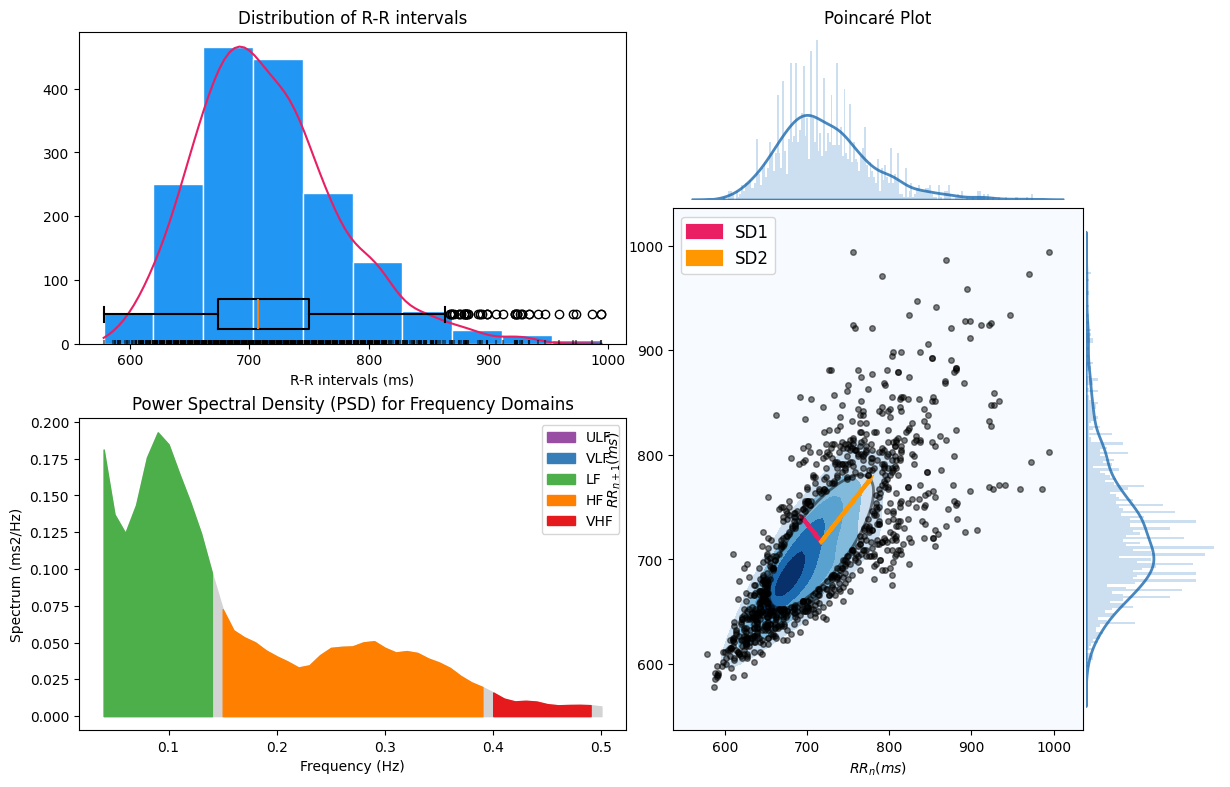

In [14]:
import neurokit2 as nk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("---------------------------------------------------------")
print("4. Comprehensive HRV Analysis (Standardized)")
print("---------------------------------------------------------")

try:
    # ---------------------------------------------------------
    # A. Sanity Check: Validate RR Intervals before Analysis
    # ---------------------------------------------------------
    # Calculate RR intervals (time between peaks) in seconds
    peaks = info["ECG_R_Peaks"]
    rr_intervals = np.diff(peaks) / sampling_rate
    
    # Check for physiological validity (0.3s to 2.0s is the normal range)
    if np.min(rr_intervals) < 0.3:
        print("[WARNING] Found RR intervals < 0.3s. Possible noise/false peaks detected.")
    if np.max(rr_intervals) > 2.0:
        print("[WARNING] Found RR intervals > 2.0s. Possible missed beats detected.")
        
    print(f"Processed {len(peaks)} heartbeats over {len(data)/sampling_rate:.1f} seconds.")

    # ---------------------------------------------------------
    # B. Calculate ALL HRV Metrics
    # ---------------------------------------------------------
    # 'nk.hrv' automatically computes Time, Frequency, and Non-Linear domains.
    # It uses the standard methods described in the NeuroKit2 documentation.
    hrv_metrics = nk.hrv(info, sampling_rate=sampling_rate, show=True)
    
    # ---------------------------------------------------------
    # C. Save Diagnostic Visualization (Poincaré Plot & PSD)
    # ---------------------------------------------------------
    # This plot is essential to visually confirm the data quality (outliers appear as scattered points).
    fig = plt.gcf()
    fig.set_size_inches(12, 8)
    plt.savefig('hrv_diagnostic_plot.png', dpi=300)
    print("[Success] Visual diagnostic saved as 'hrv_diagnostic_plot.png'")

    # ---------------------------------------------------------
    # D. Display Key Features for Cognitive Load
    # ---------------------------------------------------------
    print("\n--- Key Features for Cognitive Load Analysis ---")
    
    # 1. Time Domain (Parasympathetic/Vagal Tone)
    # RMSSD is the gold standard for short-term vagal tone.
    if 'HRV_RMSSD' in hrv_metrics.columns:
        print(f"1. RMSSD (Vagal Tone):       {hrv_metrics['HRV_RMSSD'].values[0]:.2f} ms")
    if 'HRV_SDNN' in hrv_metrics.columns:
        print(f"2. SDNN (Total Variability): {hrv_metrics['HRV_SDNN'].values[0]:.2f} ms")
    
    # 2. Frequency Domain (Sympathetic/Parasympathetic Balance)
    # LF/HF ratio indicates stress balance.
    if 'HRV_LFHF' in hrv_metrics.columns:
        print(f"3. LF/HF Ratio (Stress):     {hrv_metrics['HRV_LFHF'].values[0]:.2f}")
    
    # 3. Non-Linear Domain (Complexity & Chaos)
    # These are crucial for AI models predicting cognitive states.
    if 'HRV_SD1' in hrv_metrics.columns:
        print(f"4. SD1 (Poincaré Width):     {hrv_metrics['HRV_SD1'].values[0]:.2f}")
    if 'HRV_SampEn' in hrv_metrics.columns:
        print(f"5. Sample Entropy:           {hrv_metrics['HRV_SampEn'].values[0]:.2f}")

    # ---------------------------------------------------------
    # E. Export Results
    # ---------------------------------------------------------
    output_hrv_file = "hrv_features.csv"
    hrv_metrics.to_csv(output_hrv_file, index=False)
    print(f"\n[Success] All {len(hrv_metrics.columns)} HRV features saved to: {output_hrv_file}")
    
except Exception as e:
    print(f"Error in HRV calculation: {e}")
    print("Hint: Ensure the signal is long enough (min 2-3 minutes) for frequency analysis.")

In [ ]:
# Save the analyzed features to the Results folder
output_path = os.path.join('..', 'Results', 'final_hrv_results.csv')

# Ensure Results folder exists
os.makedirs(os.path.join('..', 'Results'), exist_ok=True)

hrv_metrics.to_csv(output_path, index=False)
print(f"Analysis complete. Results saved to: {output_path}")